# REINFORCEMENT LEARNING: Problem set 2
## Sergio-Yersi Villegas Pelegrín
### *June 2022*
#### **Approximate Dynamic Programming**

# Modules, functions and parameters

We will begin by importing the relevant modules that we will be using during this first problem set.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from numpy.random import choice

Then, we define the generalized functions that we will be using throughout the exercises, which are briefly described below.

In [31]:
def action(a_type, q_low, q_high):
    
    """
    Given the type of service rate it gets
    as input, returns the corresponding q(a) value.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    
    """
    if a_type == 'low':
        return q_low
    else:
        return q_high

def cost(a_type, q_low, q_high):
    """
    Given the type of service rate it gets
    as input, returns the corresponding cost value,
    associated to the action type. It calls the 
    above 'action' function.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    """    
    a = action(a_type, q_low, q_high)
    if a == q_low:
        return 0
    else:
        return 0.01

def reward(a_type, q_low, q_high,x,N):
    """
    Given the type of service rate it gets
    as input, returns the corresponding reward value,
    associated to the corresponding action and cost
    which are computed by calling the previous functions,
    for each state x.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    x: state
    N: maximum state (N-1 if starting at 0)
    
    """      
    c = cost(a_type, q_low, q_high)
    return -((x/N)**2)-c

def policy_type(N,pol_type):
    """
    Given the policy type,
    returns a vector with the 
    actions it will perform in 
    each state.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    
    """
    policy = np.full(N,'low', dtype='<U16')
    if pol_type == 'agg':
        for i in range(50,N):
            policy[i] = 'high'
    elif pol_type == 'high':
        policy = np.full(N,'high', dtype='<U16')
    return policy   

def feature_map(map_type, x, N):
    
    """
    Given the map type,
    returns a vector with the 
    corresponding feature map
    for the given state x.
    
    map_type: type of feature map
    x: state to compute the map
    N: maximum state (N-1 if starting at 0)
    
    """
        
    if map_type == 'fine':
        return [1 if i==x else 0 for i in range(N)]   
    elif map_type == 'coarse':
        return [1 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]   
    else:
        phi1 = [1 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]
        phi2 = [(x-5*(i-1))/5 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]
        return phi1+phi2

def theta_func(map_type,x,N):
    """
    Given the map type,
    returns a vector of 0s with the 
    length of the corresponding
    feature map for the given state x.
    
    map_type: type of feature map
    x: state to compute the map
    N: maximum state (N-1 if starting at 0)
    
    """
    length = len(feature_map(map_type, x, N))
    return np.zeros((length))

Finally, we define the fixed parameters that are provided in the instructions.

In [32]:
N = 100 # Maximum amount of states
max_iter = 100 # Maximum number of iterations to perform
q_low = 0.51 # q value for low service rate
q_high = 0.6 # q value for high service rate
p = 0.5 # rate at which new requests arrive into the queue
gamma = 0.9 # Discount factor
s0 = 99 # Initial state (full queue)
iter_list = [10000,100000,1000000,10000000] # Sample transitions to try
map_list = ['fine','coarse','piecewise'] # Feature maps to try

# Problem 1

In this first problem, we will be computing the value functions associated to each policy type and comparing the obtained results for each one of them. We are going to be implementing the two methods we have been proposed: temporal difference and least squares temporal difference. Moreover, the two policies that will be analyzed are:

- Lazy policy: always using low service rate.
- Aggressive policy: using low or high service rate depending on wheter the queue is short (x<50) or long((x>=50), respectively.

Below, we describe the two methods inside each function and import the results, which we previously computed in the first notebook, for all the possible combination of parameters: four different sample transitions values and three feature maps.

## Temporal Difference

In [33]:
def temporal_difference(s0,N,pol_type,max_iter,a,b,q_low,q_high,map_type,p,gamma,optimal_policy=None):
    """
    Given a policy and an initial state, computes TD with the 'expected'
    next state and the corresponding feature maps. At each iteration, it updates
    the theta vector and re-defines the old values as the new ones, so the next
    iteration will use the right ones for both theta and the new state. When we have looped
    over all the iterations, we already have the final, updated theta, so we can finally
    create our approximated value function results for each state.
    
    s0: initial state
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    max_iter: sample transitions
    a: tuning parameter
    b: tuning parameter
    q_low: q value for low service rates
    q_high: q value for high service rates
    map_type: type of feature map
    p: new requests arrival rate
    gamma: discount factor
    optimal policy: using an optimal policy if given (None as default)
    """
    policy = optimal_policy if optimal_policy is not None else policy_type(N, pol_type)
    theta = theta_func(map_type,s0,N)
    states = [i for i in range(N)]
    for k in range(1,max_iter):
        alpha = a/(k+b)
        q = action(policy[s0], q_low, q_high)
        if s0==N-1:
            p_dec = (1-p)*q
            p_eq = 1 - (1-p)*q
            s_prime = choice(a=[s0-1,s0], p=[p_dec,p_eq])
        elif s0==0:
            p_inc = p*(1-q)
            p_eq = 1-p*(1-q)
            s_prime = choice(a=[s0+1,s0], p=[p_inc,p_eq])
        else:
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            s_prime = choice(a=[s0+1,s0-1,s0], p=[p_inc,p_dec,p_eq])
        f_x = feature_map(map_type, s0, N)
        f_next = feature_map(map_type, s_prime, N)
        delta = reward(policy[s0],q_low,q_high,s0,N) + gamma*np.dot(theta,f_next)-np.dot(theta,f_x)
        new_theta = theta + alpha*delta*np.array(f_x)
        theta = new_theta
        s0 = s_prime
    values = [np.dot(new_theta,feature_map(map_type, i, N)) for i in states]
    return values

## Least Squares Temporal Difference

In [34]:
def lstd(s0,N,pol_type,max_iter,a,b,q_low,q_high,map_type,p,gamma,optimal_policy=None):
    """
    Given a policy and an initial state, computes LSTD with the 'expected'
    next state and the corresponding feature maps. When we have looped
    over all the iterations, we compute the inverse matrix using the Moore–
    Penrose pseudoinverse and then the final, updated theta, so we can finally
    create our approximated value function results for each state.

    
    Uses same parameters as the function 'temporal_difference()'
    """
    policy = optimal_policy if optimal_policy is not None else policy_type(N, pol_type)
    theta = theta_func(map_type,s0,N)
    states = [i for i in range(N)]
    mat = 0
    b_T = 0
    for k in range(1,max_iter):
        alpha = a/(k+b)
        q = action(policy[s0], q_low, q_high)
        if s0==N-1:
            p_dec = (1-p)*q
            p_eq = 1 - (1-p)*q
            s_prime = choice(a=[s0-1,s0], p=[p_dec,p_eq])
        elif s0==0:
            p_inc = p*(1-q)
            p_eq = 1-p*(1-q)
            s_prime = choice(a=[s0+1,s0], p=[p_inc,p_eq])
        else:
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            s_prime = choice(a=[s0+1,s0-1,s0], p=[p_inc,p_dec,p_eq])
        f_x = np.matrix(feature_map(map_type, s0, N))
        f_next = np.matrix(feature_map(map_type, s_prime, N))
        mat += f_x.T*((f_x-gamma*f_next))
        b_T += reward(policy[s0],q_low,q_high,s0,N)*f_x
        s0 = s_prime
    mat=np.linalg.pinv(mat)
    theta = b_T*mat
    values = [np.dot(theta,feature_map(map_type, i, N)) for i in states]
    return values

## Results

We import the results from the csv files we created in the first notebook and plot the results for all the combinations of parameters.

In [101]:
def plots(results,algorithm):
    """
    Plots all the combinations of results for
    each algorithm.
    
    results: DataFrame with the results of the given algorithm
    algorithm: name of the algorithm used
    """
    tickers = results.columns
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 20))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(algorithm + " results", fontsize=40, y=0.95)

    # loop through tickers and axes
    for ticker, ax in zip(tickers, axs.ravel()):
        # filter df for ticker and plot on specified axes
        results[ticker].plot(ax=ax, c='darkviolet')

        # chart formatting
        ax.set_title(ticker.upper())
        #ax.get_legend().remove()
        ax.set_xlabel("States")
        ax.set_ylabel("Lazy-aggresive values")
        
        ax.axvline(x=50, c='darkred', label='State 50')
        ax.axvline(x=80, c='darkblue', label='State 80')
        #plt.legend()
    plt.show()  

In [102]:
results_td = pd.read_csv('/Volumes/GoogleDrive/Mi unidad/BSE/TERM 3/RL/data/td_results.csv')
results_td

,$10^4$fine,$10^4$coarse,$10^4$piece,$10^5$fine,$10^5$coarse,$10^5$piece,$10^6$fine,$10^6$coarse,$10^6$piece,$10^7$fine,$10^7$coarse,$10^7$piece
0,-0.000789,-0.000880,-0.034170,0.000258,-0.001847,-0.000391,-0.000429,-0.010213,0.001102,0.000107,0.001141,0.000407
1,-0.002373,-0.000880,-0.040485,0.000586,-0.001847,-0.000643,-0.000016,-0.010213,0.000811,0.000479,0.001141,0.000515
2,-0.005372,-0.000880,-0.046801,0.002127,-0.001847,-0.000894,-0.000363,-0.010213,0.000519,0.000407,0.001141,0.000624
3,-0.009992,-0.000880,-0.053117,0.003572,-0.001847,-0.001146,-0.001390,-0.010213,0.000228,-0.000283,0.001141,0.000733
4,-0.019419,-0.000880,-0.059432,0.003004,-0.001847,-0.001397,-0.001982,-0.010213,-0.000063,0.001228,0.001141,0.000841
...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.017344,6.398451,-20.323724,1.730245,4.195385,-1.784049,4.229773,6.369958,4.278747,8.087956,8.036946,13.363649
96,4.310067,6.398451,-19.776103,6.525104,4.195385,-1.380734,8.207204,6.369958,3.796525,6.679110,8.036946,13.074995
97,6.764292,6.398451,-19.228482,8.314266,4.195385,-0.977419,6.717517,6.369958,3.314303,6.809919,8.036946,12.786342
98,4.501343,6.398451,-18.680860,8.402470,4.195385,-0.574105,1.823345,6.369958,2.832080,4.476483,8.036946,12.497688


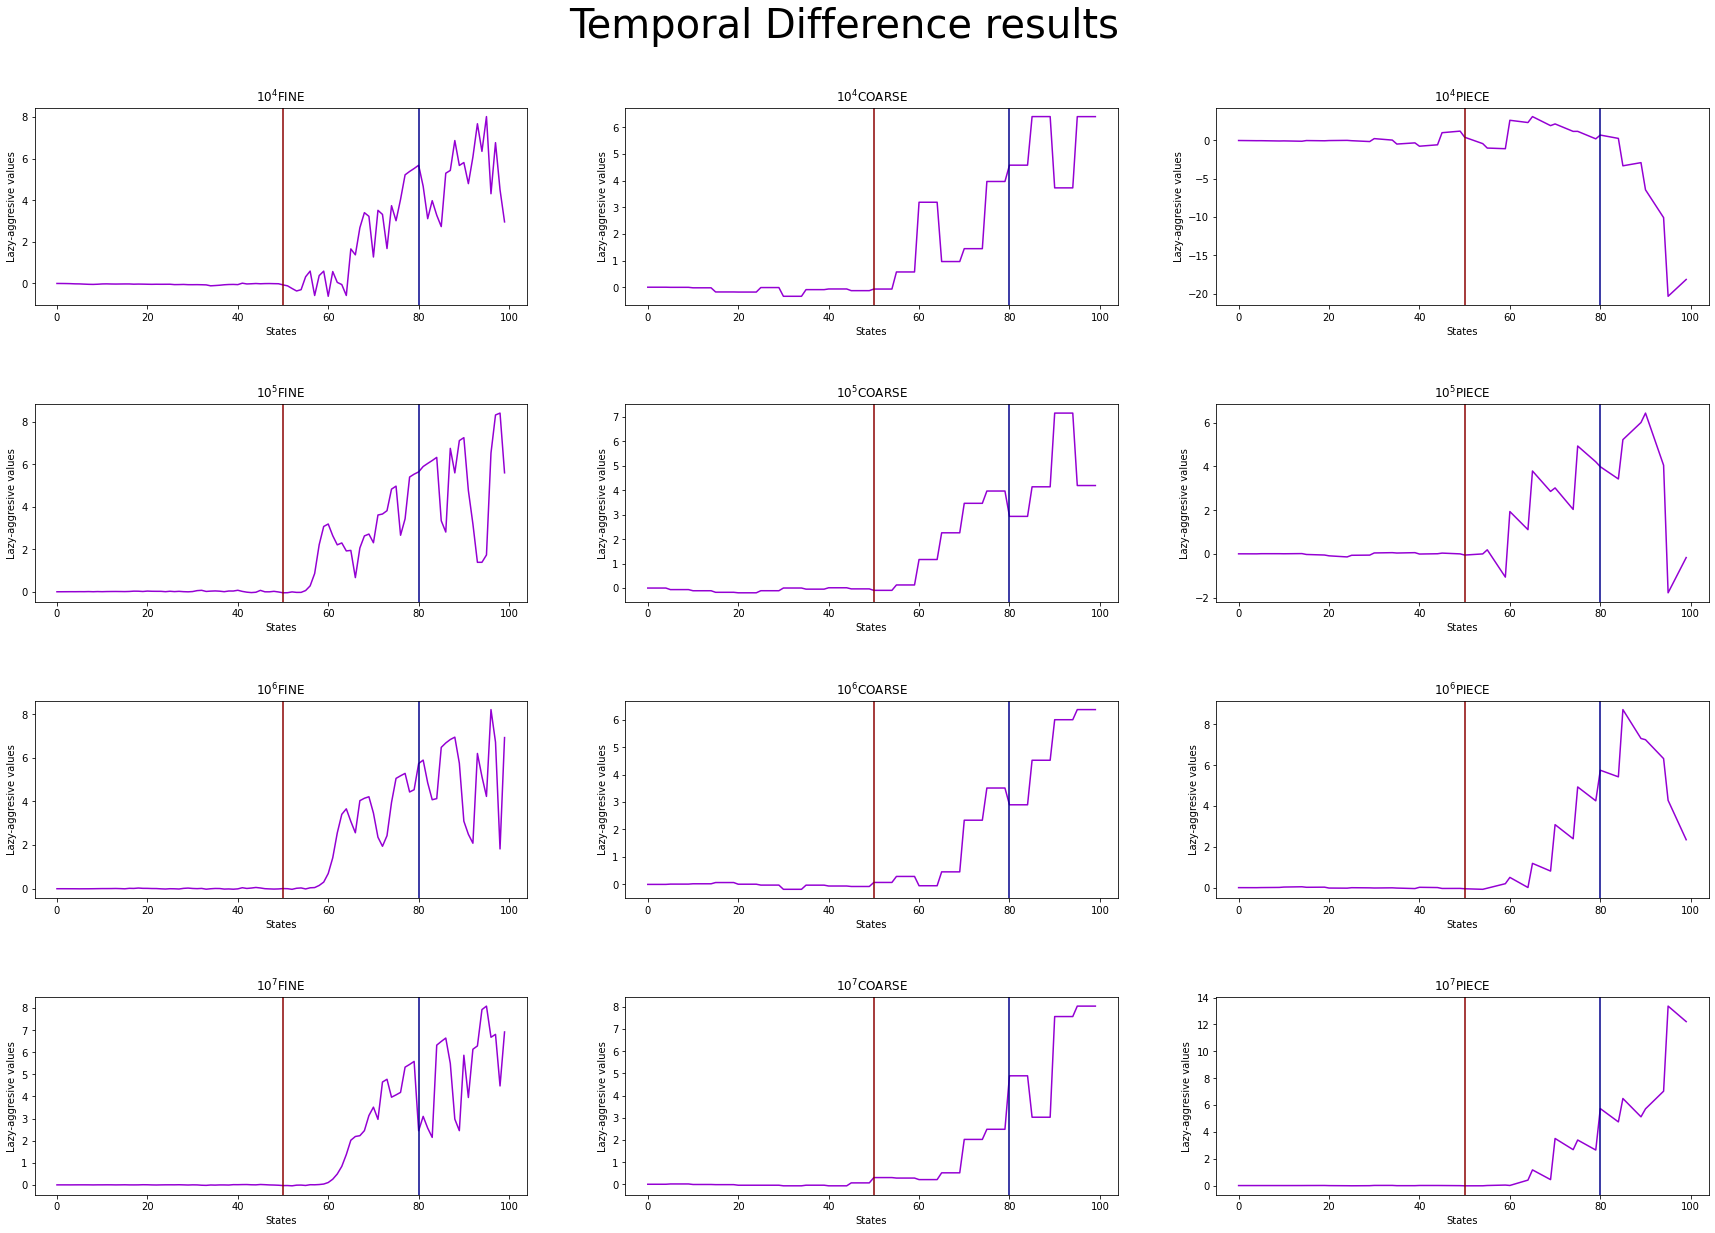

In [103]:
plots(results_td,'Temporal Difference')

In [104]:
results_lstd = pd.read_csv('/Volumes/GoogleDrive/Mi unidad/BSE/TERM 3/RL/data/lstd_results.csv')
results_lstd

,$10^4$fine,$10^4$coarse,$10^4$piece,$10^5$fine,$10^5$coarse,$10^5$piece,$10^6$fine,$10^6$coarse,$10^6$piece,$10^7$fine,$10^7$coarse,$10^7$piece
0,-0.003113,-0.018044,0.000486,0.000012,0.001088,0.000009,0.000031,-0.000002,0.000006,0.000014,0.000260,-0.000006
1,-0.004442,-0.018044,0.000852,0.000061,0.001088,0.000078,0.000026,-0.000002,0.000036,0.000025,0.000260,-0.000011
2,-0.007482,-0.018044,0.001218,-0.000069,0.001088,0.000148,-0.000004,-0.000002,0.000066,0.000036,0.000260,-0.000016
3,-0.011691,-0.018044,0.001584,0.000158,0.001088,0.000218,-0.000149,-0.000002,0.000096,0.000066,0.000260,-0.000021
4,-0.017688,-0.018044,0.001950,0.000562,0.001088,0.000288,-0.000194,-0.000002,0.000126,0.000061,0.000260,-0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.088985,0.396875,-0.106850,0.318339,2.060911,-0.343890,0.171111,0.632153,-0.263856,1.796739,1.644064,-0.106105
96,0.027141,0.396875,0.494481,0.526807,2.060911,-0.080201,0.496688,0.632153,-0.021223,2.829010,1.644064,0.424393
97,0.219062,0.396875,1.095811,0.935751,2.060911,0.183489,1.008821,0.632153,0.221411,3.328125,1.644064,0.954891
98,0.533383,0.396875,1.697142,1.283941,2.060911,0.447178,2.006022,0.632153,0.464044,4.248231,1.644064,1.485389


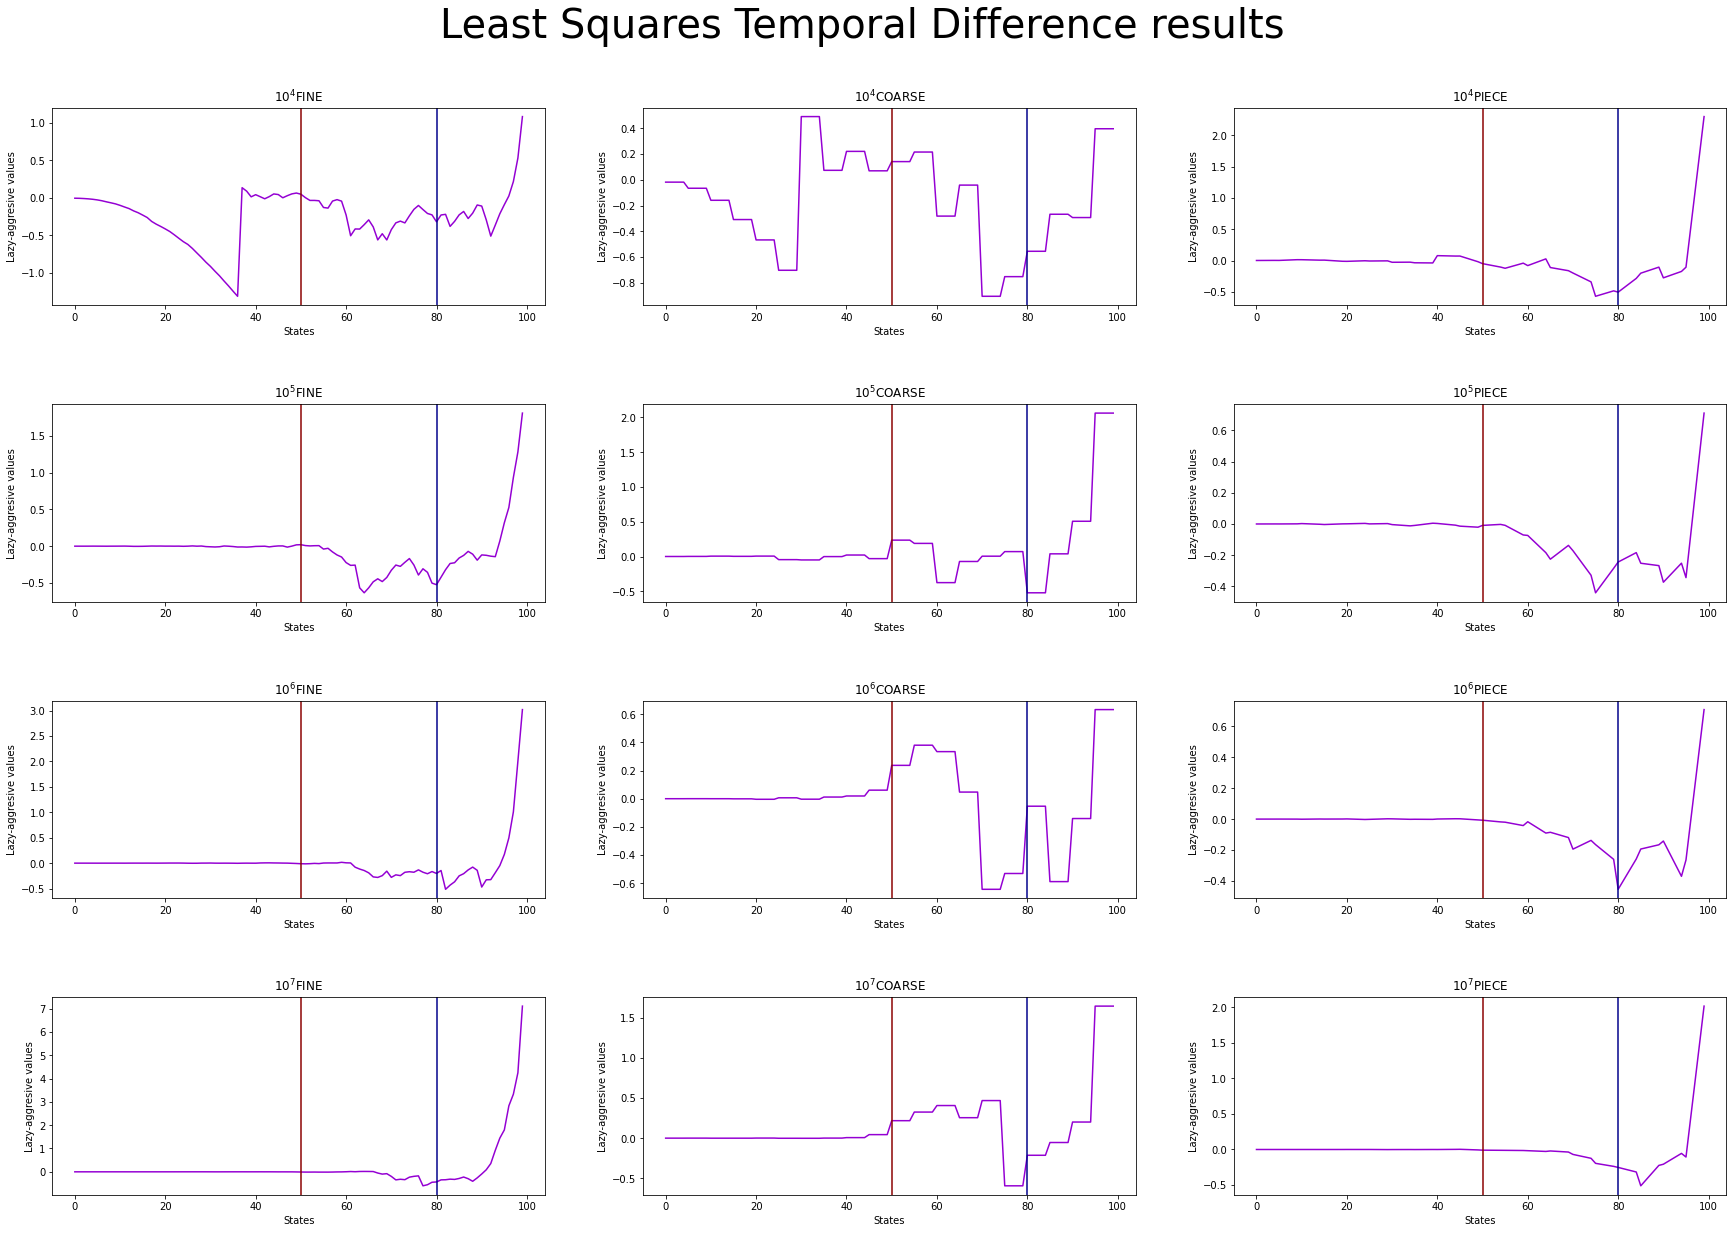

In [105]:
plots(results_lstd,'Least Squares Temporal Difference')

## Discussion of both methods

As we can see in both methods, specially for high values of sample transitions, the changes occur around state 50, as in the previous problem set. However, the shapes of the value functions difference between the two policies clearly differ from the original difference from the first problem set. Nevertheless, we can see approximate behaviors after each of the highlighted states: from 50 to 80, the value function differences tend to have a decreasing behavior, while from the 80th state to the last, they increase, as it happened in the first problem set. 

Overall, we can conclude that these approximations do not match the original value function differences obtained in the first problem set, since the approximations using these feature maps do not provide conclusive and equivalent results.

# Problem 2

Now, for this second problem, we will be obtaining the optimal policy using an approximated policy iteration. We will be computing the value functions (using LSTD with 100,000 sample transitions) for different values for the maximum amount of iterations used, together with the three feature maps. We finally store these results in a DataFrame object. Moreover, we also store the optimal policy obtained in each case. Finally, we will be comparing the obtained optimal policy with the ones from the first problem set, by means of: firstly, plotting the value functions of the approximated (with 10 and 100 iterations); secondly, showing the final policies obtained in each case, by computing the corresponding service rates and plotting them.

In order to perform the approximated policy iteration, we will need a transition matrix with all the corresponding probabilities of each state. Therefore, we define the function below that computes the corresponding matrix according to the given policy type.

In [38]:
def transition_matrix(N, pol_type, q_low, q_high, p): 
    """
    Defines the transition matrix with all the corresponding
    queue movement probabilities associated to each state,
    according to a policy type given as input.
    Three cases are identified, each one with specific expressions 
    for the probability of each queue movement:
    empty queue, full queue and all the values in between.
    We define p_dec, p_inc and 
    p_eq as the probabilities of the queue decreasing, increasing and staying equal,
    respectively, as the combined probabilities according to each case.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    
    """
    transition_mat = np.zeros((N,N))
    policy = policy_type(N, pol_type)
    for x in range(N):
        q = action(policy[x], q_low, q_high)
        if x != 0 and x != N-1: 
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            transition_mat[x, x] = p_eq
            transition_mat[x,x+1] = p_inc
            transition_mat[x,x-1] = p_dec
        else:
            if x == 0:
                p_dec = 0.0
                p_inc = p*(1-q)
                p_eq = 1-p*(1-q)
                transition_mat[x,x] = p_eq
                transition_mat[x,x+1] = p_inc
            else:
                p_dec = (1-p)*q
                p_inc = 0
                p_eq = 1 - (1-p)*q
                transition_mat[x,x] = p_eq
                transition_mat[x,x-1] = p_dec
    return transition_mat

Below, we describe the used method and perform all the combinations: 10,100 iterations combined with the three feature maps.

In [68]:
def policy_iteration(s0,iterations,a,b,map_type,pol_type,N, initial_pol, update_pol,\
                     pol_type_low, pol_type_high, q_low, q_high, p, max_iter, gamma):
    """
    Iterates over all the states during a maximum number of iterations
    and computes two value functions at each state for the two possible actions. 
    Morever, three cases are identified, each one with specific expressions for 
    the probability of each queue movement:
    empty queue, full queue and all the values in between. At each state,
    if the value function corresponding to the initial action type is
    lower than the other (the one that will update the result), the optimal policy
    is updated accordingly. In other words, if initialized at 'low', if the value
    for 'high' is greater than the one for 'low', it is updated from 'low' to 'high',
    and viceversa if initialized oppositely.

    s0: initial state
    iterations: number of iterations
    a: tuning parameter
    b: tuning parameter    
    map_type: type of feature map    
    pol_type: policy type
    N: maximum state (N-1 if starting at 0)
    initial_pol: policy type to be initialized
    update_pol: action to be updated if it is the case
    pol_type_low: policy full of low actions
    pol_type_high: policy full of high actions
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    max_iter: sample transitions
    gamma: discount factor
    
    """
    optimal_policy = list(policy_type(N,initial_pol))
    low_pol_matrix = transition_matrix(N,pol_type_low,q_low,q_high,p)
    high_pol_matrix = transition_matrix(N,pol_type_high,q_low,q_high,p) 
  
    for k in range(iterations):
        policy_value = lstd(s0,N,pol_type,max_iter,a,b,q_low,q_high,map_type,p,gamma,optimal_policy)
        for x in range(N):
            if x==0:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x])
                
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x])        

            elif (x>0) and (x < N - 1):
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x] + \
                 low_pol_matrix[x,x-1]*policy_value[x-1])
                
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x] + \
                 high_pol_matrix[x,x-1]*policy_value[x-1])
            else:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x]*policy_value[x]+low_pol_matrix[x,x-1]*policy_value[x-1])
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x]*policy_value[x] + high_pol_matrix[x,x-1]*policy_value[x-1])

            if initial_pol == pol_type_low:
                if value_a_high > value_a_low:
                    optimal_policy[x] = update_pol
            else:
                if value_a_low > value_a_high:
                    optimal_policy[x] = update_pol  
  
    return optimal_policy        


In [69]:
results_pol_it = []
policies_pol_it = []
for itera in [10,100]:
    for i_map in map_list:
        print(i_map)
        optimal_policy = policy_iteration(s0=99,iterations=itera,a=100000,b=100000,map_type=i_map,pol_type ='agg',\
                                      N=N, initial_pol = 'low', update_pol = 'high',pol_type_low='low', \
                                      pol_type_high='high',q_low=q_low, q_high=q_high,p=p, \
                                      max_iter=100000, gamma=gamma)
        values = lstd(s0=99,N=N,pol_type='None',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type=i_map, p=p, gamma=gamma, optimal_policy=optimal_policy)
        results_pol_it.append(list(values))
        policies_pol_it.append(optimal_policy)

fine
coarse
piecewise
fine
coarse
piecewise


In [90]:
final_pol_it_results = []
for i in results_pol_it:
    res_i = [i[j].item() for j in range(len(i))]
    final_pol_it_results.append(res_i)
final_pol_it_results = pd.DataFrame(final_pol_it_results).transpose()
final_pol_it_results.columns = ['10_fine','10_coarse','10_piecewise','100_fine','100_coarse','100_piecewise']
final_pol_it_results['states'] = list(range(100))
final_pol_it_results    

,10_fine,10_coarse,10_piecewise,100_fine,100_coarse,100_piecewise,states
0,-0.003318,-0.021974,-0.001508,-0.003120,-0.022029,-0.001570,0
1,-0.004812,-0.021974,-0.005382,-0.004515,-0.022029,-0.005610,1
2,-0.007952,-0.021974,-0.009256,-0.007619,-0.022029,-0.009650,2
3,-0.012984,-0.021974,-0.013130,-0.012660,-0.022029,-0.013690,3
4,-0.019732,-0.021974,-0.017005,-0.019420,-0.022029,-0.017731,4
...,...,...,...,...,...,...,...
95,-8.911847,-8.905185,-7.367608,-8.194067,-7.729880,-9.104519,95
96,-8.817112,-8.905185,-5.343775,-7.876619,-7.729880,-8.633243,96
97,-8.684149,-8.905185,-3.319942,-6.122203,-7.729880,-8.161968,97
98,-8.496225,-8.905185,-1.296109,-5.391803,-7.729880,-7.690692,98


## Value function results

Below, we display the value functions for each feature map, where we compare the value functions obtained via the approximated policy iteration with the final optimal policy, with 10 and 100 iterations) and the value functions obtained via the original LSTD algorithm with the two original policies (lazy and aggressive).

In [ ]:
lstd_lazy_fine = lstd(s0=s0,N=N,pol_type='lazy',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='fine', p=p, gamma=gamma)
lstd_agg_fine = lstd(s0=s0,N=N,pol_type='agg',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='fine', p=p, gamma=gamma)

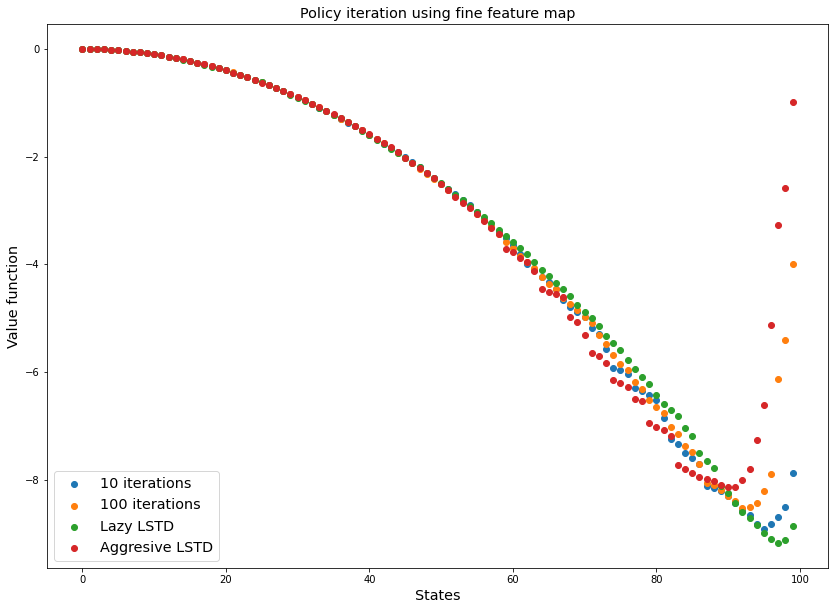

In [160]:
plt.figure(figsize=(14,10))
plt.scatter(final_pol_it_results['states'],final_pol_it_results['10_fine'], label = '10 iterations')
plt.scatter(final_pol_it_results['states'],final_pol_it_results['100_fine'], label = '100 iterations')
plt.scatter(final_pol_it_results['states'],lstd_lazy_fine, label = 'Lazy LSTD')
plt.scatter(final_pol_it_results['states'],lstd_agg_fine, label = 'Aggresive LSTD')
plt.title('Policy iteration using fine feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend(loc='lower left',fontsize='x-large')
plt.show()

In [ ]:
lstd_lazy_coarse = lstd(s0=s0,N=N,pol_type='lazy',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='coarse', p=p, gamma=gamma)
lstd_agg_coarse = lstd(s0=s0,N=N,pol_type='agg',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='coarse', p=p, gamma=gamma)

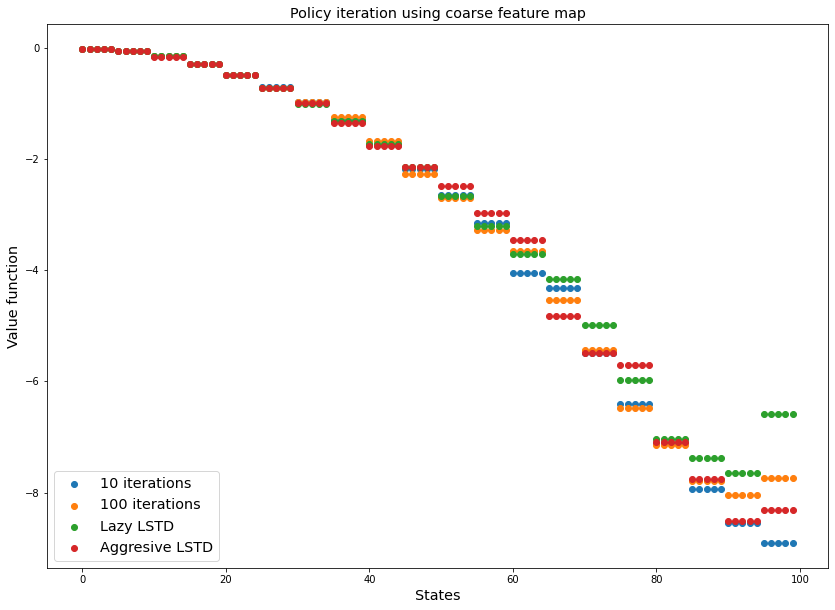

In [159]:
plt.figure(figsize=(14,10))
plt.scatter(final_pol_it_results['states'],final_pol_it_results['10_coarse'], label = '10 iterations')
plt.scatter(final_pol_it_results['states'],final_pol_it_results['100_coarse'], label = '100 iterations')
plt.scatter(final_pol_it_results['states'],lstd_lazy_coarse, label = 'Lazy LSTD')
plt.scatter(final_pol_it_results['states'],lstd_agg_coarse, label = 'Aggresive LSTD')
plt.title('Policy iteration using coarse feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend(loc='lower left',fontsize='x-large')
plt.show()

In [ ]:
lstd_lazy_piecewise = lstd(s0=s0,N=N,pol_type='lazy',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='piecewise', p=p, gamma=gamma)
lstd_agg_piecewise = lstd(s0=s0,N=N,pol_type='agg',max_iter=100000, a=100000,b=100000,q_low=q_low, q_high=q_high,\
                  map_type='piecewise', p=p, gamma=gamma)

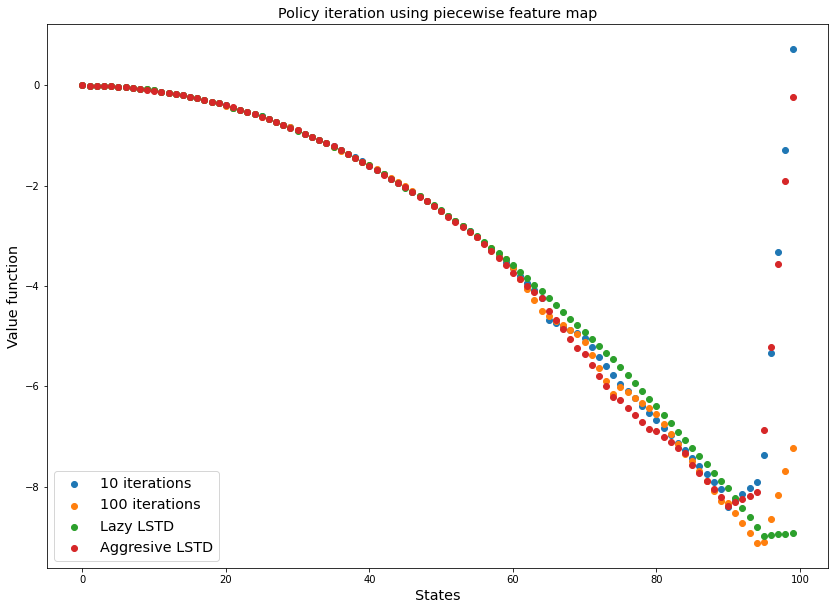

In [161]:
plt.figure(figsize=(14,10))
plt.scatter(final_pol_it_results['states'],final_pol_it_results['10_piecewise'], label = '10 iterations')
plt.scatter(final_pol_it_results['states'],final_pol_it_results['100_piecewise'], label = '100 iterations')
plt.scatter(final_pol_it_results['states'],lstd_lazy_piecewise, label = 'Lazy LSTD')
plt.scatter(final_pol_it_results['states'],lstd_agg_piecewise, label = 'Aggresive LSTD')
plt.title('Policy iteration using piecewise feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend(loc='lower left',fontsize='x-large')
plt.show()

As we can see in the figures above, the three feature maps provide similar behaviors for both iteration values used.  However, it is worth noticing that all four curves (approximated optimal policies, lazy and aggresive) are very similar in all figures: this means that the optimal policies are not being reached, since they are not outperforming the original lazy and aggresive policies. The reason of this may be due to using too few iterations when using an approximated algorithm, such as LSTD.

## Optimal vs lazy and aggresive policies: service rate comparison

Finally, we plot the service rate of each policy obtained via the approximated policy iteration method, where we have used the aforementioned combinations of iterations and feature maps. 


In [118]:
policies_df = pd.DataFrame(policies_pol_it).transpose()
policies_df.columns = ['10_fine','10_coarse','10_piecewise','100_fine','100_coarse','100_piecewise']
for col in policies_df.columns:
    policies_df['q_'+col] = policies_df.apply(lambda x: action(x[col], q_low, q_high), axis=1)
policies_df

,10_fine,10_coarse,10_piecewise,100_fine,100_coarse,100_piecewise,q_10_fine,q_10_coarse,q_10_piecewise,q_100_fine,q_100_coarse,q_100_piecewise
0,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
1,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
2,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
3,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
4,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...
95,high,high,low,high,high,high,0.60,0.60,0.51,0.60,0.60,0.60
96,low,low,low,high,low,low,0.51,0.51,0.51,0.60,0.51,0.51
97,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51
98,low,low,low,low,low,low,0.51,0.51,0.51,0.51,0.51,0.51


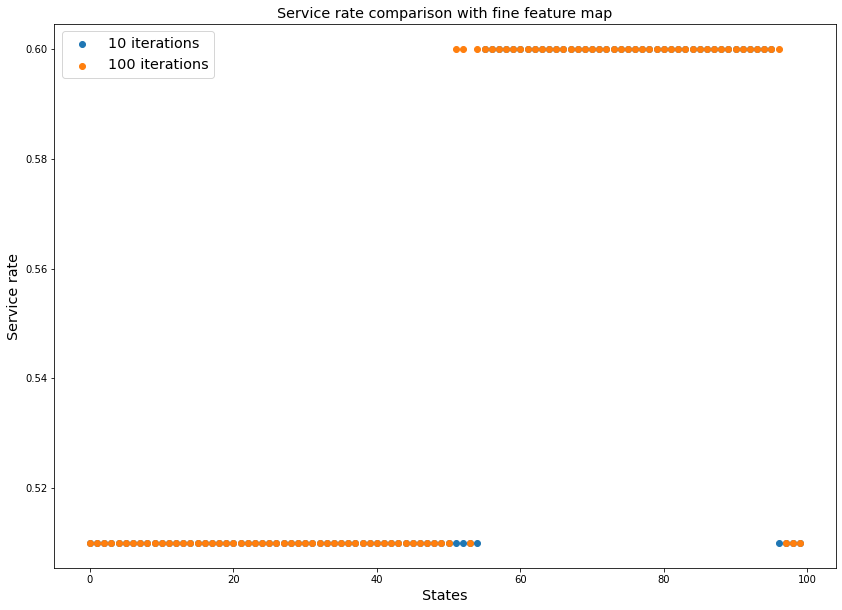

In [167]:
plt.figure(figsize=(14,10))
plt.scatter(range(N),policies_df['q_10_fine'], label = '10 iterations')
plt.scatter(range(N),policies_df['q_100_fine'], label = '100 iterations')
plt.title('Service rate comparison with fine feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Service rate', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

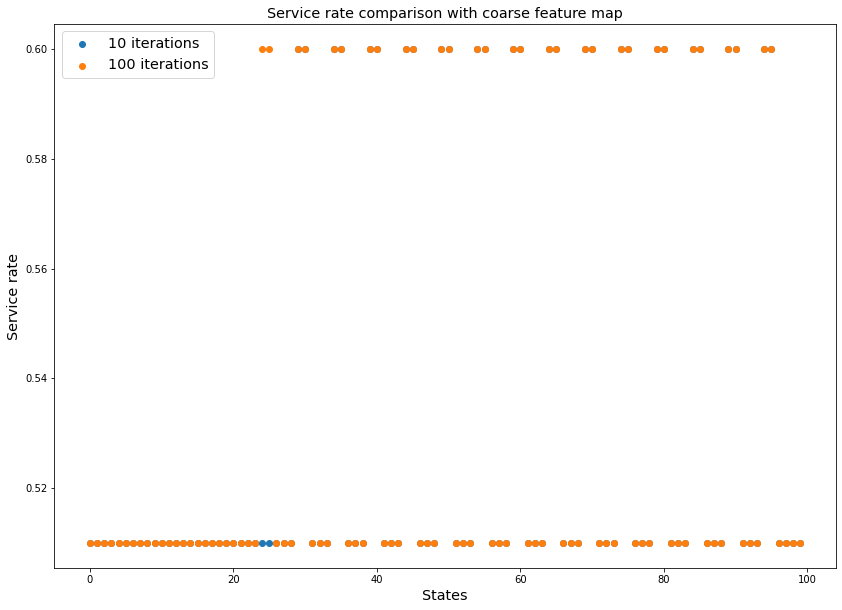

In [168]:
plt.figure(figsize=(14,10))
plt.scatter(range(N),policies_df['q_10_coarse'], label = '10 iterations')
plt.scatter(range(N),policies_df['q_100_coarse'], label = '100 iterations')
plt.title('Service rate comparison with coarse feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Service rate', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

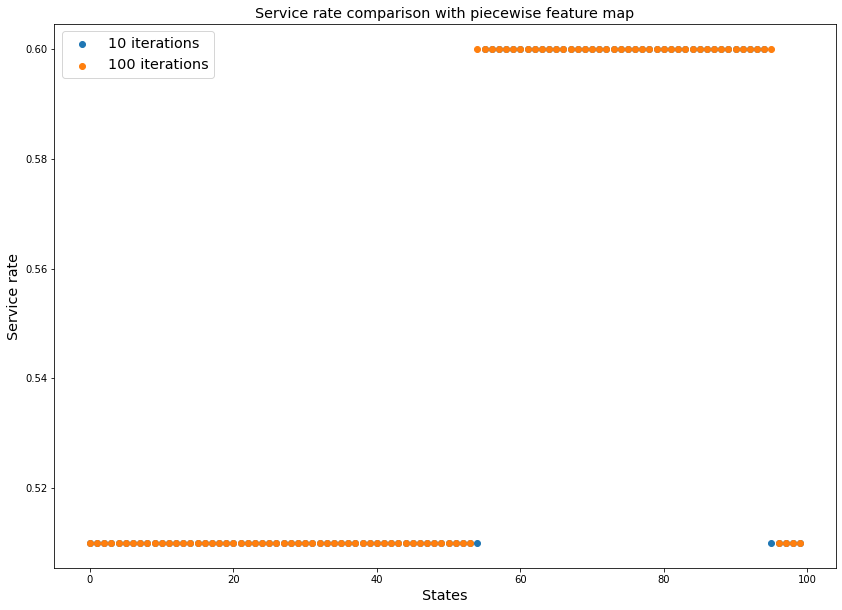

In [169]:
plt.figure(figsize=(14,10))
plt.scatter(range(N),policies_df['q_10_piecewise'], label = '10 iterations')
plt.scatter(range(N),policies_df['q_100_piecewise'], label = '100 iterations')
plt.title('Service rate comparison with piecewise feature map', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Service rate', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

Looking at the figures above, we can see how the fine and piecewise feature maps provide a very similar optimal policy to the one obtained in the first problem set, since it changes from low to high service rate close to the 60th state. However, they are not completely equivalent, since in the last states it goes back to the low service rate (being in concordance to the obtained results in the value functions comparison from this problem set), opposite to what happened in the first problem set (where only in the last state the optimal policy went back to the low service rate). Then, regarding the coarse feature map, we can see that it switches from low to high service rate every 2-3 states, which is clearly far away from the original optimal policy from the first problem set.